# MDJ–CPMC Case-Level Merge and Pretrial Window Construction

## Overview
This notebook prepares a **case-level dataset** by merging Pennsylvania
Magisterial District Judge (MDJ) filings with Court of Common Pleas (CPMC)
records.

The main goals are to:
1. Normalize and clean MDJ and CPMC docket identifiers
2. Aggregate charge-level records into **case-level MDJ observations**
3. Remove cases that were **held in custody** and are not pretrial-eligible
4. Merge MDJ cases with CPMC to detect **case transfers**
5. Construct a **pretrial window** for each case
6. Export a clean, analysis-ready dataset for downstream modeling

## Output
- `mdj_cpmc.csv`: Case-level dataset with pretrial start/end dates and transfer flags

## Notes for Future Users
- This notebook assumes MDJ data is **charge-level** and collapses it to cases
- All transformations are deterministic and reproducible
- Variable naming favors clarity over brevity

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
mdj = pd.read_csv("csv data/CMU AOPC MDJ Filings 2015-2018.csv", low_memory=False)

In [3]:
cpmc = pd.read_csv('csv data/cpmc_small.csv', low_memory=False)

In [4]:
# 1. Normalize docket numbers
def normalize_docket(df, cols):
    """
    Normalize docket-related columns by:
    - casting to string
    - stripping whitespace
    - converting to uppercase
    """
    for col in cols:
        if col in df.columns:
            df[col] = (
                df[col]
                .astype(str)
                .str.strip()
                .str.upper()
            )
    return df

mdj = normalize_docket(mdj, ['docketnumber'])
cpmc = normalize_docket(cpmc, ['originatingdocketnumber'])

In [5]:
# 2. Convert date columns to datetime
# We explicitly coerce invalid dates to NaT to avoid silent failures
date_cols_mdj = ['filingdate', 'offensedispositiondate']
date_cols_cpmc = ['offensedispositiondate']

for col in date_cols_mdj:
    if col in mdj.columns:
        mdj[col] = pd.to_datetime(mdj[col], errors='coerce')

for col in date_cols_cpmc:
    if col in cpmc.columns:
        cpmc[col] = pd.to_datetime(cpmc[col], errors='coerce')

In [6]:
# 3. Aggregate CPMC to case level
# Each originating docket may appear multiple times in CPMC
# We keep the latest disposition date
cpmc_case = (
    cpmc
    .dropna(subset=['originatingdocketnumber'])
    .groupby('originatingdocketnumber', as_index=False)
    .agg({'offensedispositiondate': 'max'})  # latest disposition
    .rename(columns={'offensedispositiondate': 'cpmc_offensedispositiondate'})
)

In [7]:
# Count unique docket numbers
unique_dockets = mdj['docketnumber'].nunique(dropna=True)

print(f"There are {unique_dockets:,} unique docket numbers in the MDJ dataset.")

There are 519,040 unique docket numbers in the MDJ dataset.


In [8]:
# 4. Aggregate MDJ to case level
# ---- helper functions ----
def safe_max_yn_flag(x):
    """Y/N flags → 1 if any Y, else 0."""
    if x.isna().all():
        return 0
    x_clean = x.dropna().astype(str).str.strip().str.upper()
    return (x_clean == "Y").astype(int).max()

def safe_dv_flag(x):
    """DV flag → 1 if any non-null value exists."""
    return 1 if x.notna().any() else 0

def join_all(x):
    """join all distinct non-null values, sorted, separated by '; '"""
    vals = x.dropna().astype(str).str.strip().unique()
    if len(vals) == 0:
        return pd.NA
    return "; ".join(sorted(vals))

# ---- columns we have ----
cols = [
 'docketnumber',
 'citationcomplaintnumber',
 'otn',
 'citytownboro',
 'countyofoffense',
 'casestatus',
 'filingdate',
 'offensedate',
 'complaintdate',
 'arrestdate',
 'title',
 'section',
 'subsection',
 'sequencenumber',
 'grade',
 'offensedisposition',
 'offensedispositiondate',
 'defendantdisplayname',
 'dob',
 'gender',
 'race',
 'ethnicity',
 'defendantcounty',
 'ori',
 'fine',
 'fineadjustment',
 'cost',
 'costadjustment',
 'restitution',
 'restitutionadjustment',
 'sentencingjudge',
 'penaltyeventtype',
 'programtype',
 'programperiod',
 'startdate',
 'enddate',
 'facilitylocation',
 'limitedaccessoffenseindicator',
 'casedisposition',
 'casecategory',
 'zipcode',
 'defenseattorneyname',
 'defenseattorneyrepresentationtyp',
 'id'
]

# make sure the date-ish ones are datetime
for dcol in ['filingdate', 'offensedispositiondate', 'offensedate',
             'complaintdate', 'arrestdate', 'startdate', 'enddate']:
    if dcol in mdj.columns:
        mdj[dcol] = pd.to_datetime(mdj[dcol], errors='coerce')

# ---- build the aggregation ----
agg_dict = {
    # timeline
    'filingdate': 'min',
    'offensedate': 'min',
    'complaintdate': 'min',
    'arrestdate': 'min',
    'offensedispositiondate': 'max',
    'startdate': 'min',
    'enddate': 'max',

    # basic case-level “first” fields
    'casestatus': 'first',
    'casecategory': 'first',
    'casedisposition': 'first',
    'citytownboro': 'first',
    'countyofoffense': 'first',
    'defendantdisplayname': 'first',
    'dob': 'first',
    'gender': 'first',
    'race': 'first',
    'ethnicity': 'first',
    'defendantcounty': 'first',
    'zipcode': 'first',
    'defenseattorneyname': 'first',
    'defenseattorneyrepresentationtyp': 'first',
    'ori': 'first',

    # money
    'fine': 'first',
    'fineadjustment': 'first',
    'cost': 'first',
    'costadjustment': 'first',
    'restitution': 'first',
    'restitutionadjustment': 'first',

    # program/sentence info
    'sentencingjudge': 'first',
    'penaltyeventtype': 'first',
    'programtype': 'first',
    'programperiod': 'first',
    'facilitylocation': 'first',
    'limitedaccessoffenseindicator': 'first',
}

# charge-level fields → keep all values
for col in ['title', 'section', 'subsection', 'grade',
            'offensedisposition', 'citationcomplaintnumber', 'sequencenumber']:
    if col in mdj.columns:
        agg_dict[col] = join_all

# if you have flag columns (from your other file), hook them in here:
for flag_col in ['dv_flag', 'juvflag', 'laflag', 'conv_flag', 'susp_flag']:
    if flag_col in mdj.columns:
        if flag_col == 'dv_flag':
            agg_dict[flag_col] = safe_dv_flag
        else:
            agg_dict[flag_col] = safe_max_yn_flag

# keep id and otn too
agg_dict['id'] = 'first'
if 'otn' in mdj.columns:
    agg_dict['otn'] = 'first'

# ---- finally, collapse to case level ----
mdj_case = (
    mdj
    .groupby('docketnumber', as_index=False)
    .agg(agg_dict)
)

print(f"collapsed to case level: {len(mdj_case):,} rows")

collapsed to case level: 519,040 rows


In [9]:
# Remove the held cases
# Held cases are not pretrial-eligible and must be excluded

# 1) load held list
held = pd.read_stata("CP MDJ Dockets Held.dta")

# 2) normalize possible docket columns
for col in ["docketnumber", "originatingdocketnumber"]:
    if col in held.columns:
        held[col] = (
            held[col]
            .astype(str)
            .str.strip()
            .str.upper()
        )

# 3) build one set of held dockets
held_all = pd.concat(
    [held[c] for c in ["docketnumber", "originatingdocketnumber"] if c in held.columns]
).dropna().unique()

print(f"Held dockets in file: {len(held_all):,}")

# 4) filter your case-level MDJ
before = len(mdj_case)
mdj_case = mdj_case[~mdj_case["docketnumber"].isin(held_all)]
after = len(mdj_case)

print(f"MDJ case-level before: {before:,}")
print(f"MDJ case-level after : {after:,}")
print(f"Removed (held)       : {before - after:,}")


Held dockets in file: 204,816
MDJ case-level before: 519,040
MDJ case-level after : 452,265
Removed (held)       : 66,775


In [10]:
# 5. Merge MDJ with CPMC
merged_case = mdj_case.merge(
    cpmc_case,
    left_on='docketnumber',
    right_on='originatingdocketnumber',
    how='left'
)

In [11]:
merged_case.columns.to_list()

['docketnumber',
 'filingdate',
 'offensedate',
 'complaintdate',
 'arrestdate',
 'offensedispositiondate',
 'startdate',
 'enddate',
 'casestatus',
 'casecategory',
 'casedisposition',
 'citytownboro',
 'countyofoffense',
 'defendantdisplayname',
 'dob',
 'gender',
 'race',
 'ethnicity',
 'defendantcounty',
 'zipcode',
 'defenseattorneyname',
 'defenseattorneyrepresentationtyp',
 'ori',
 'fine',
 'fineadjustment',
 'cost',
 'costadjustment',
 'restitution',
 'restitutionadjustment',
 'sentencingjudge',
 'penaltyeventtype',
 'programtype',
 'programperiod',
 'facilitylocation',
 'limitedaccessoffenseindicator',
 'title',
 'section',
 'subsection',
 'grade',
 'offensedisposition',
 'citationcomplaintnumber',
 'sequencenumber',
 'id',
 'otn',
 'originatingdocketnumber',
 'cpmc_offensedispositiondate']

In [12]:
# make sure the date columns in merged_case are datetime
mdj_filing_col = 'filingdate'
mdj_dispo_col = 'offensedispositiondate'
for col in [mdj_filing_col, mdj_dispo_col, 'cpmc_offensedispositiondate']:
    if col in merged_case.columns:
        merged_case[col] = pd.to_datetime(merged_case[col], errors='coerce')

# 1. start of window = MDJ filing
merged_case['pretrial_start'] = merged_case[mdj_filing_col]

# 2. end of window = later of MDJ dispo and CPMC dispo (if transferred)
end_parts = []
if mdj_dispo_col in merged_case.columns:
    end_parts.append(merged_case[mdj_dispo_col])
if 'cpmc_offensedispositiondate' in merged_case.columns:
    end_parts.append(merged_case['cpmc_offensedispositiondate'])

if len(end_parts) == 2:
    merged_case['pretrial_end'] = pd.concat(end_parts, axis=1).max(axis=1)
elif len(end_parts) == 1:
    merged_case['pretrial_end'] = end_parts[0]
else:
    merged_case['pretrial_end'] = pd.NaT

# 3. transferred flag = did this MDJ docket find a match in CPMC?
merged_case['transferred'] = merged_case['cpmc_offensedispositiondate'].notna()

# 4. optional: duration in days for QA / plotting
merged_case['pretrial_days'] = (
    merged_case['pretrial_end'] - merged_case['pretrial_start']
).dt.days

print(merged_case[['docketnumber', 'pretrial_start', 'pretrial_end', 'transferred']].head())
print(merged_case['transferred'].value_counts())


               docketnumber      pretrial_start        pretrial_end  \
0  MJ-02000-CR-0000001-2017 2017-01-03 09:54:00 2017-09-29 15:14:00   
1  MJ-02000-CR-0000001-2018 2018-01-01 09:52:00 2018-10-22 13:59:00   
2  MJ-02000-CR-0000002-2015 2015-09-01 13:25:00 2015-10-14 08:45:00   
3  MJ-02000-CR-0000002-2017 2017-01-03 10:47:00 2017-05-31 09:27:00   
4  MJ-02000-CR-0000002-2018 2018-01-02 10:05:00 2019-08-28 13:45:00   

   transferred  
0         True  
1         True  
2        False  
3         True  
4         True  
transferred
True     350399
False    101866
Name: count, dtype: int64


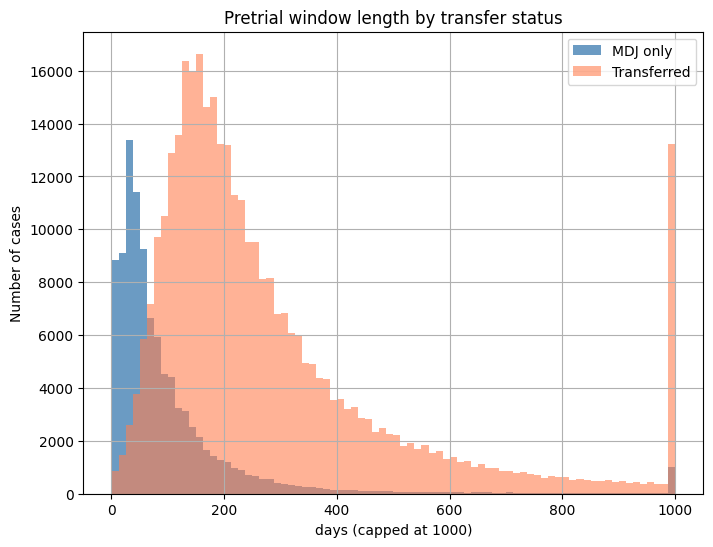

In [13]:
# cap pretrial_days at 1000 for readability
merged_case['pretrial_days_capped'] = merged_case['pretrial_days'].clip(upper=1000)

plt.figure(figsize=(8,6))
merged_case.loc[~merged_case['transferred'], 'pretrial_days_capped'].hist(
    bins=80, alpha=0.8, label='MDJ only', color='steelblue'
)
merged_case.loc[merged_case['transferred'], 'pretrial_days_capped'].hist(
    bins=80, alpha=0.6, label='Transferred', color='coral'
)
plt.title("Pretrial window length by transfer status", fontsize=12)
plt.xlabel("days (capped at 1000)")
plt.ylabel("Number of cases")
plt.legend()
plt.show()


In [14]:
# select 2 transferred and 1 non-transferred
examples = pd.concat([
    merged_case.loc[merged_case['transferred']].sample(2, random_state=1),
    merged_case.loc[~merged_case['transferred']].sample(1, random_state=1)
])

# select relevant columns
cols_to_show = [
    'docketnumber',
    'filingdate',
    'offensedispositiondate',  # MDJ disposition
    'cpmc_offensedispositiondate',  # CPMC disposition (if any)
    'pretrial_start',
    'pretrial_end',
    'transferred'
]

# format for readability
example_table = examples[cols_to_show].sort_values('transferred', ascending=False)
display(example_table)


,docketnumber,filingdate,offensedispositiondate,cpmc_offensedispositiondate,pretrial_start,pretrial_end,transferred
75491,MJ-05207-CR-0000331-2018,2018-06-20 15:51:00,2018-07-02 08:30:00,2023-06-29 11:03:00,2018-06-20 15:51:00,2023-06-29 11:03:00,True
119453,MJ-06306-CR-0000281-2017,2017-09-25 11:49:00,2017-10-25 11:00:00,2018-03-05 09:29:00,2017-09-25 11:49:00,2018-03-05 09:29:00,True
65993,MJ-05201-CR-0000203-2018,2018-05-10 14:39:00,2018-07-26 09:00:00,NaT,2018-05-10 14:39:00,2018-07-26 09:00:00,False


In [15]:
# Check shapes
print(cpmc_case.shape)
print(mdj_case.shape)
print(merged_case.shape)

(568163, 2)
(452265, 44)
(452265, 51)


In [16]:
merged_case.to_csv('mdj_cpmc.csv')